In [2]:
import pickle
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import dgl
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import sys
import os
import seaborn as sns
sys.path.append("../learning")
from utils import get_seed, get_num_params,  MultipleTensors
from args import get_args
from data_utils import get_model, get_loss_func, MIODataLoader, MIODataset
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
from controller import venti_controler
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
torch.manual_seed(0)
torch.cuda.empty_cache()

In [9]:
# Load models
model_paths_all = [
    "../learning/data/checkpoints/co2_all_MIOEGPT_meanvarianceuncertainty_0228_00_10_00.pt", 
    "../learning/data/checkpoints/co2_all_MIOEGPT_meanvarianceuncertainty_0228_15_25_04.pt", 
    "../learning/data/checkpoints/co2_all_MIOEGPT_meanvarianceuncertainty_0228_15_31_54.pt", 
    "../learning/data/checkpoints/co2_all_MIOEGPT_meanvarianceuncertainty_0301_16_02_36.pt",
    "../learning/data/checkpoints/co2_all_MIOEGPT_meanvarianceuncertainty_0301_16_03_28.pt", 
]
models_lst = []
device = torch.device('cuda:1')
with torch.no_grad():
    for model_path in model_paths_all:
        result = torch.load(model_path, map_location=torch.device("cuda:1"))
        args = result['args']
        model_dict = result['model']
        model = get_model(args,)
        model.load_state_dict(model_dict)
        model.eval()
        args = result['args']
        models_lst.append(model.to(device))
# Load datas
train_path = "../learning/dataset/train_data_norm.pkl"
dataset_name = "co2"
train_dataset = MIODataset(train_path, name=dataset_name, train=True, train_num=args.train_num, sort_data=args.sort_data, normalize_y=args.use_normalizer,normalize_x=args.normalize_x)
train_loader = MIODataLoader(train_dataset, batch_size=1, drop_last=False)
test_path = "../learning/dataset/test_data_norm.pkl"
test_dataset = MIODataset(test_path, name=dataset_name, train=False, test_num=args.test_num,
                            sort_data=args.sort_data,
                            normalize_y=args.use_normalizer,
                            normalize_x=args.normalize_x, y_normalizer=train_dataset.y_normalizer,
                            x_normalizer=train_dataset.x_normalizer, up_normalizer=train_dataset.up_normalizer)
test_loader = MIODataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False)
g, u_p, f = list(iter(test_loader))[0]
controller = venti_controler(models_lst, train_dataset, g, u_p, f, device)

Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Load dataset finished 0.3697223663330078
Training with 3893 samples


/home/jason/anaconda3/envs/ol/lib/python3.9/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


Target features are normalized using unit transformer
tensor([[619.4855, 620.2894, 621.0497, 621.8191, 622.4127, 622.9807]]) tensor([[155.6501, 155.7280, 155.7338, 155.8135, 155.9132, 155.9175]])
Target features are normalized using unit transformer
Input features are normalized using unit transformer
Load dataset finished 0.13507676124572754
Testing with 1126 samples
Target features are normalized using unit transformer
Input features are normalized using unit transformer


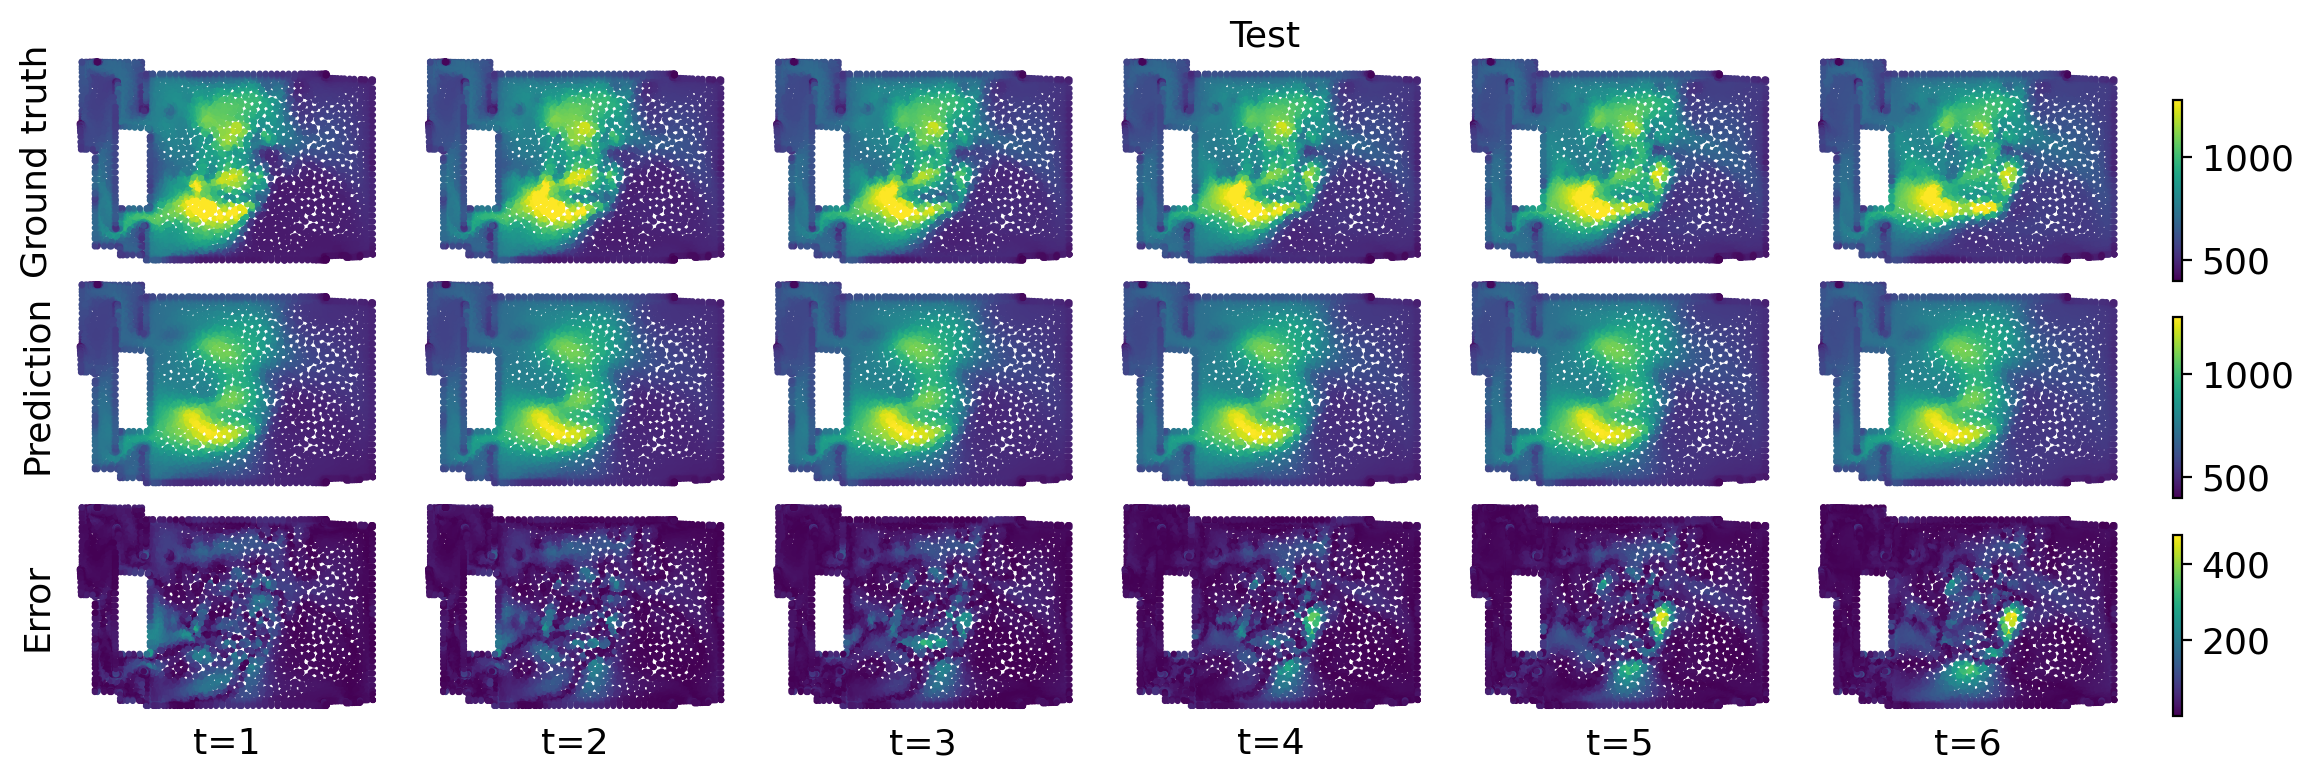

In [15]:
i = 14
g, u_p, f = list(iter(test_loader))[i]
g = g.to(device)
u_p = u_p.to(device)
f = f.to(device)
x, y = g.ndata['x'][:,0].cpu().numpy(), g.ndata['x'][:,1].cpu().numpy()
gt = g.ndata['y']
gt = train_dataset.y_normalizer.transform(gt, inverse=True).cpu().numpy()
mu, _ = controller.get_prediction(g, u_p, f)
mu =  train_dataset.y_normalizer.transform(mu.detach(), inverse=True).cpu().numpy()

values = [gt, mu, np.abs(gt-mu)]
labels = ["Ground truth", "Prediction", "Error"]
nrows, ncols = 3, 6
plt.rcParams['font.size'] = 13
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4))
for row_idx in range(nrows):
    value = values[row_idx]
    if row_idx == 1: value = mu
    if row_idx < 2:
        vmin = np.min(values[1][:,0])
        vmax = np.max(values[1][:,0])
    elif row_idx == 2:
        vmin = np.min(value)
        vmax = np.max(value)
    else:
        vmin = np.min(values[0][:,-1])
        vmax = np.max(values[0][:,-1])
    row_scatter_list = []
    for col_idx in range(ncols):
        sc = axes[row_idx][col_idx].scatter(x, y, c=value[:,col_idx], cmap="viridis", vmin=vmin, vmax=vmax, s=1.5)
        row_scatter_list.append(sc)
        axes[row_idx][col_idx].set_yticks([])
        axes[row_idx][col_idx].set_xticks([])
        for spine in axes[row_idx][col_idx].spines.values():
            spine.set_visible(False)
    fig.colorbar(row_scatter_list[-1], ax=axes[row_idx, :])
    axes[row_idx][0].set_ylabel(labels[row_idx])
for col_idx in range(ncols):
    axes[-1][col_idx].set_xlabel(f"t={col_idx+1}")

fig.suptitle("Test", fontsize=13)
plt.subplots_adjust(top=0.94, wspace=0.08, 
                    hspace=0.02, right=0.77) 
plt.show()